# GCC's ssc-cdi : ptychography pipeline for Cateretê v0.1
 
- #### Questions? E-mail gcc@lnls.br
- #### Documentation about the ssc-cdi package: https://gcc.lnls.br/wiki/

## Imports

In [1]:
%matplotlib widget
import os, json
import numpy as np
import sscInstall
import sscCdi
import sscResolution

print(f'sscCdi version: {sscCdi.__version__}')
print(f'sscResolution version: {sscResolution.__version__}')

sscCdi version: 0.5.1
sscResolution version: 0.5.8


## Inputs

In [4]:
input_dict = {
    
'beamline': 'CAT',
'detector': '540D',
'debug': False,

"data_folder": "/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/data/ptycho2d/",
"acquisition_folders": ["ss_6keV28m_c"],
"projections": [0],

'CPUs': 64,
'GPUs': [0, 1],

'using_direct_beam': False,
'DP_center': [1393,1406],
'fill_blanks': False,
'keep_original_negative_values': False,
'suspect_border_pixels': 3,
'detector_ROI_radius': 1350,

'position_rotation': -0.003,

'object_padding': 20,

'incoherent_modes': 0,
'probe_support': [300, 0, 0],
'fresnel_number': -0.001,

"initial_obj": ["random"],
"initial_probe": ["inverse"],

'Algorithm1': {'Batch': 64,
                'Beta': 0.995,
                'Epsilon': 0.01,
                'Iterations': 70,
                'Name': 'RAAR',
                'ProbeCycles': 4,
                'TV': 0},

'Algorithm2': {'Batch': 64,
                'Epsilon': 0.01,
                'Iterations': 50,
                'Name': 'GL',
                'ObjBeta': 0.97,
                'ProbeBeta': 0.95,
                'TV': 0.0001},

'Algorithm3': {'Batch': 64,
                'Epsilon': 0.1,
                'Iterations': 5,
                'Name': 'GL',
                'ObjBeta': 0.5,
                'ProbeBeta': 0.5,
                'TV': 0.01},
}

input_dict = sscCdi.caterete.cat_ptycho_processing.define_paths(input_dict)

	Proposal path:  /ibira/lnls/labs/tepui/home/yuri.tonin/00000000/data/ptycho2d/
	Acquisition folder:  ss_6keV28m_c
	Output path: /ibira/lnls/labs/tepui/home/yuri.tonin/00000000/proc/recons/ss_6keV28m_c


# Run at Cluster

In [5]:
# server = sscInstall.connect_server()    

In [6]:
json_filepath_path = sscCdi.cat_ptycho_processing.save_input_dictionary(input_dict)
# sscCdi.run_at_cluster(server,json_filepath_path,queue='petro',gpus=input_dict["GPUs"],cpus=input_dict["CPUs"],jobName='JOB',script_path = "/ibira/lnls/labs/tepui/home/yuri.tonin/ssc-cdi/bin/caterete_ptycho.py",slurm_path = '/ibira/lnls/beamlines/caterete/apps/gcc-jupyter/inputs/')

# Run Locally

## Restoration

In [ ]:
restoration_dict_list, restored_data_info_list = sscCdi.caterete.cat_restoration.restoration_CAT(input_dict) # restoration of all frames; restored DPs saved at temporary folder

	Restoration of folder ss_6keV28m_c
	Using 1 of 1 angle(s)


## Ptychography

In [ ]:
input_dict, obj, probe, probe_positions = sscCdi.caterete.cat_ptycho_processing.cat_ptychography(input_dict,restoration_dict_list,restored_data_info_list)
obj, probe = sscCdi.misc.save_volume_from_parts(input_dict)
sscCdi.misc.save_variable(input_dict, obj,flag='object')
sscCdi.misc.save_variable(input_dict,probe,flag='probe')
sscCdi.misc.save_json_logfile(input_dict) 
sscCdi.misc.delete_temporary_folders(input_dict)

In [ ]:
if 1: # phase
    preview = np.angle(obj)
else: # magnitude
    preview = np.abs(obj)

sscCdi.misc.deploy_visualizer(preview,title='Sinogram',cmap='gray')

## Crop object

In [10]:
input_dict['crop'] = [1400,2000,1300,1900]
cropped_object = sscCdi.caterete.cat_ptycho_processing.crop_sinogram(input_dict,obj,probe_positions)
if 1: # phase
    cropped_object = np.angle(cropped_object)
else: # magnitude
    cropped_object = np.abs(cropped_object)

In [11]:
sscCdi.misc.deploy_visualizer(cropped_object,title='Cropped sinogram',cmap='gray')

## Unwrap object

In [12]:
phase = sscCdi.caterete.unwrap_in_parallel(cropped_object)
sscCdi.misc.save_variable(input_dict,phase, flag = 'object_unwrapped')

Using 32 parallel processes


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.87it/s]


In [23]:
sscCdi.misc.deploy_visualizer(phase,title='Unwrapped',cmap='gray')

## Fourier Ring Correlation

	Resolution via halfbit criterion: 35.41 nm


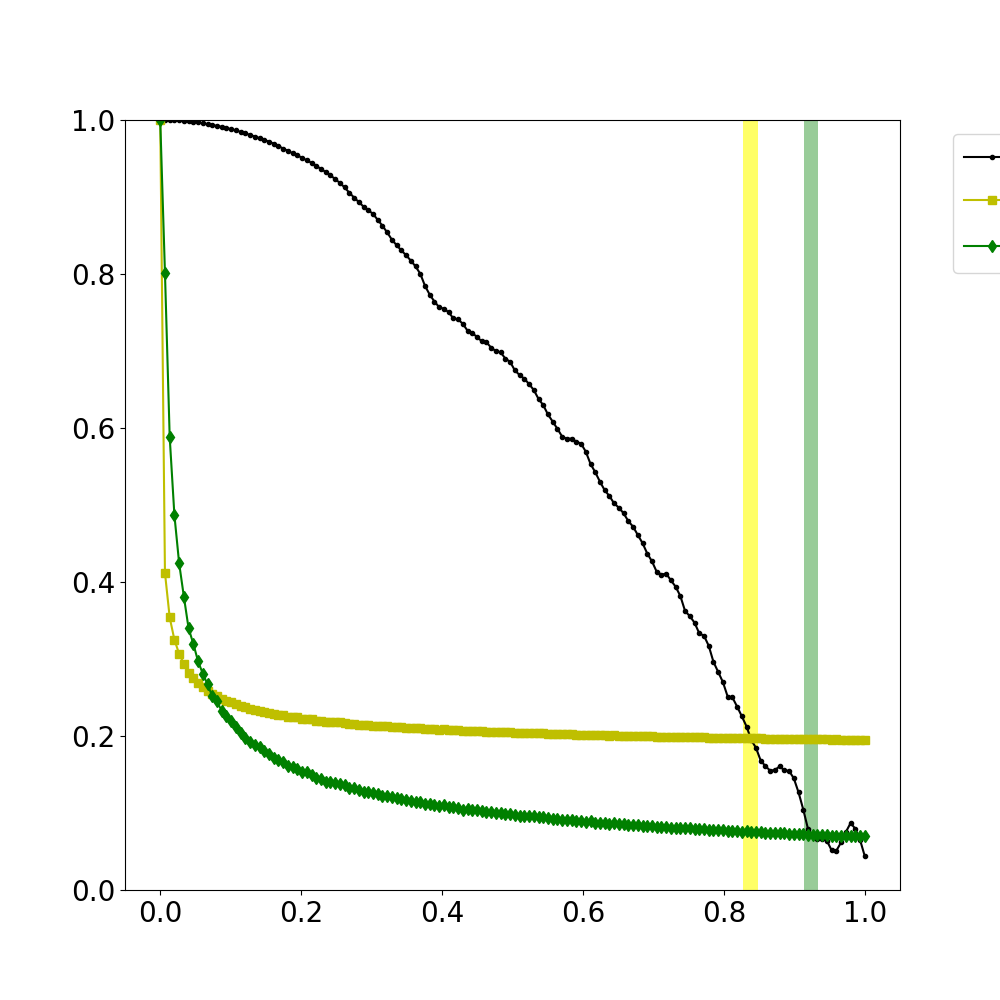

In [18]:
frame = 0

if 1: # FRC on phase image
    img = phase[frame]
else: # else, on absorption image
    img = np.abs(cropped_object)[frame]

padding = 0
sharpness = 10
radius = 0.8

dic = sscResolution.frc.computep( sscResolution.frc.window( img, padding, [sharpness, radius] ) , input_dict["CPUs"] ) 
print(f"\tResolution via halfbit criterion: {1e9*input_dict['object_pixel']/dic['x']['H']:.2f} nm")

sscResolution.frc.plot(dic, {'label': "Resolution", 'unit': "nm", 'pxlsize': input_dict['object_pixel']*1e9} )